# TASK 2.1.1

In [74]:
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
from matplotlib import pyplot as plt


In [69]:
data = pd.read_csv('./SMAI-Dataset-customer-dataset/data.csv')
data

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


In [70]:
data.info()                 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Index            2000 non-null   int64
 1   Gender           2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [71]:
data = data.drop(['Index'], axis = 1)
data = data.values
data

array([[     0,      0,     67, ..., 124670,      1,      2],
       [     1,      1,     22, ..., 150773,      1,      2],
       [     0,      0,     49, ...,  89210,      0,      0],
       ...,
       [     0,      0,     31, ...,  86400,      0,      0],
       [     1,      1,     24, ...,  97968,      0,      0],
       [     0,      0,     25, ...,  68416,      0,      0]])

In [164]:
class GMM:
    def __init__(self):
        self.n_components = None
        self.weights = None
        self.means = None
        self.iter = None    
        self.covariances = None
        self.data = None
        self.log_likelihood_dict = {}

    def log_likelihood(self):
        n_samples, n_features = self.data.shape
        likelihoods = np.zeros((n_samples, self.n_components))
        for i in range(self.n_components):
            mulvar_norm = multivariate_normal(self.means[i], self.covariances[i])
            mulvar_norm = mulvar_norm.pdf(self.data)
            likelihoods[:, i] = self.weights[i] * mulvar_norm

        return np.sum(np.log(np.sum(likelihoods, axis=1)))
    

    def fit(self, data, n_components, n_iterations):
        n_samples, n_features = data.shape
        
        self.n_components = n_components
        self.n_iter = n_iterations
        X_mean = np.mean(data, axis=0)
        X_std = np.std(data, axis=0)

        # Initialize parameters
        self.data = (data - X_mean) / X_std
        self.weights = np.random.rand(n_components)
        self.weights /= np.sum(self.weights)
        self.means = self.data[np.random.choice(n_samples, n_components, replace=False),:]
        self.covariances = [np.cov(self.data.T) for _ in range(n_components)]

        
        # EM algorithm
        prev_log_likelihood = -np.inf
        for iteration in range(n_iterations):

            # E-step
            membership = np.zeros((n_samples, self.n_components))
            for i in range(n_components):
                mulvar_norm = multivariate_normal(self.means[i], self.covariances[i])
                mulvar_norm = mulvar_norm.pdf(self.data)
                membership[:, i] = self.weights[i] * mulvar_norm
            
            membership /= np.sum(membership, axis = 1)[:, None]
            # print(membership)

            # M-step
            for i in range(self.n_components):
                self.weights[i] = np.mean(membership[:, i])
                self.means[i] = np.sum(membership[:, i].reshape(-1, 1) * self.data, axis=0) / np.sum(membership[:, i])
                diff = self.data - self.means[i]
                self.covariances[i] = (membership[:, i].reshape(-1, 1) * diff).T @ diff / np.sum(membership[:, i])
                epsilon = (1e-6) * np.identity(n_features)
                self.covariances[i] += epsilon

            # Log likelihood
            log_likelihood = self.log_likelihood()
            self.log_likelihood_dict[iteration] = log_likelihood
            if abs(prev_log_likelihood - log_likelihood) < 1e-6:
                break
            prev_log_likelihood = log_likelihood
        self.label_predict = np.argmax(membership, axis=1)
        
    def predict(self):
        return self.label_predict
    def get_parameters(self):
        return {
            'n_components': self.n_components,
            'weights': self.weights,
            'means': self.means,
            'covariances': self.covariances,
            'dict' : self.log_likelihood_dict
        }




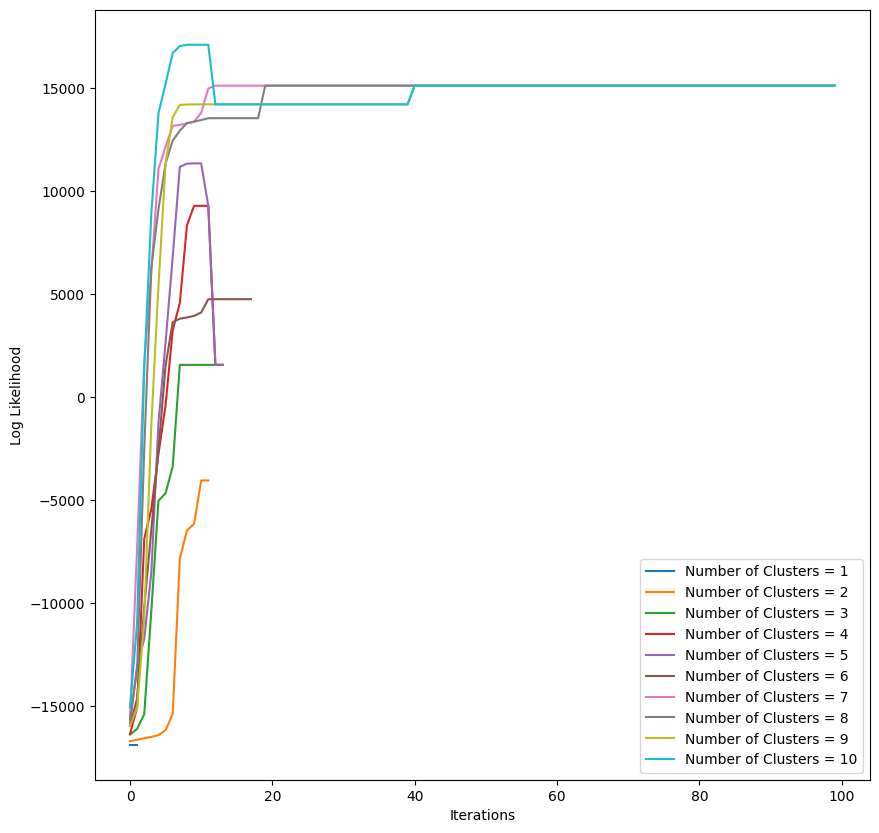

In [104]:
num_components = 10
iter = 100
gmm = GMM()
plt.figure(figsize=(10, 10))
for i in range(1, num_components+1): 
    gmm.fit(data, i, iter)
    params = gmm.get_parameters()
    plt.plot(list(params['dict'].keys()), list(params['dict'].values()), label = 'Number of Clusters = {}'.format(i))
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.legend()
plt.show()
    

Evidently, as the number of clusters rises, so does the log-likelihood of the data. It climbs until a certain point before settling on a value after a limited number of iterations. This is so because a measure of how well a model fits the data is the log-likelihood. The model's ability to fit the data better and better as the number of clusters rises, and as a result, the log-likelihood rises. However, the model can no longer fit the data any better after a certain point, and as a result, the log-likelihood converges to a certain number.

# TASK 2.1.2

In [126]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np


In [134]:
wine_data = load_wine()
# print(wine_data)
# print(wine_data.data.shape)
X = wine_data.data
y = wine_data.target

print(X.shape)
print(y.shape)
print(wine_data.feature_names)
print(wine_data.target_names)


(178, 13)
(178,)
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [157]:
# # PCA

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
data1 = (X-X_mean)/X_std 

pca = PCA(n_components=2)
data = pca.fit_transform(data1)

In [160]:
# Initialize lists to store BIC and AIC scores
bic_scores = []
aic_scores = []
iter = 100
max_components = 30
gmm = GMM()
# Try different numbers of components/clusters
for n_components in range(2, max_components+1):
    # Fit GMM model
    gmm.fit(data, n_components, iter)
    params = gmm.get_parameters()
    n_samples, n_features = data.shape
    parameters = (n_components * n_features) + (n_components - 1) + (n_components * n_features * (n_features + 1) / 2)
    aic_scores.append(-2*params['dict'][max(params['dict'])] + 2*parameters)
    bic_scores.append(-2*params['dict'][max(params['dict'])] + np.log(n_samples)*parameters)
    

# Find the optimal number of clusters based on BIC and AIC (lower values are better)
optimal_clusters_aic = np.argmin(aic_scores)+2
optimal_clusters_bic = np.argmin(bic_scores)+2

print(f"Optimal Number of Clusters (AIC): {optimal_clusters_aic}")
print(f"Optimal Number of Clusters (BIC): {optimal_clusters_bic}")


Optimal Number of Clusters (AIC): 30
Optimal Number of Clusters (BIC): 3


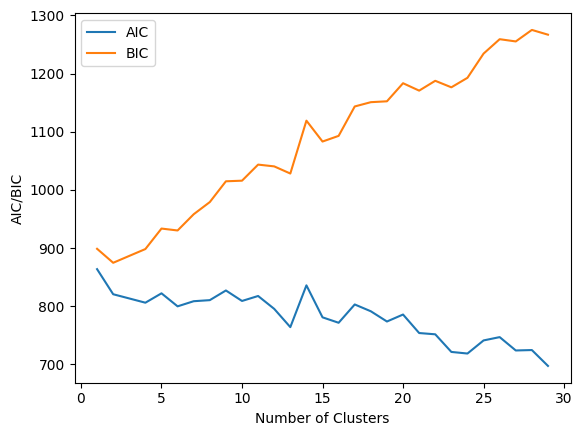

In [161]:
plt.plot(range(1, len(aic_scores) + 1), aic_scores, label='AIC')
plt.plot(range(1, len(bic_scores) + 1), bic_scores, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC/BIC')
plt.legend()
plt.show()

In [181]:
gmm = GMM()
gmm .fit(data, optimal_clusters_aic, iter)
# params = gmm.get_parameters()
labels = gmm.predict()
silhouette = silhouette_score(data, labels)
print("AIC Silhouette-> " , silhouette)


AIC Silhouette->  0.05426477977740812


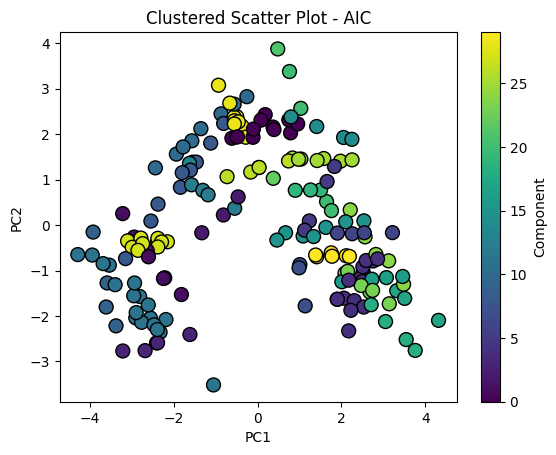

In [179]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=100, edgecolor='k')
plt.title('Clustered Scatter Plot - AIC')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Component')
plt.show()

In [180]:
gmm = GMM()
gmm .fit(data, optimal_clusters_bic, iter)
# params = gmm.get_parameters()
labels = gmm.predict()
silhouette = silhouette_score(data, labels)
print("BIC Silhouette-> " , silhouette)


BIC Silhouette->  0.5581473461293222


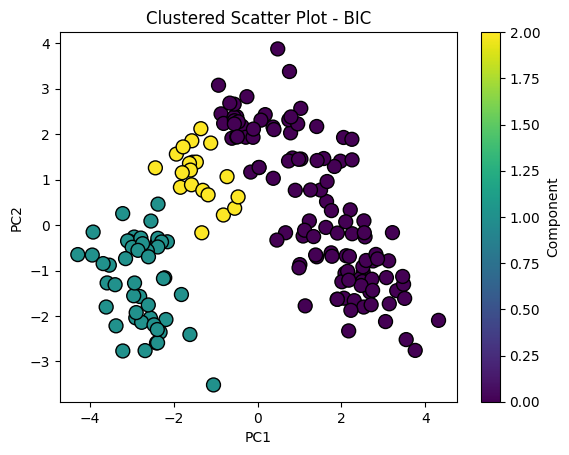

In [176]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=100, edgecolor='k')
plt.title('Clustered Scatter Plot - BIC')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Component')
plt.show()

The cluster points produced by the bic scores are significantly more useful. This is due to the fact that as we adjust our maximum value for the number of data samples, the optimal number of clusters simply continues to rise, according to the aic scores. 

In [196]:
kmeans_aic = KMeans(n_clusters=optimal_clusters_aic)
kmeans_bic = KMeans(n_clusters=optimal_clusters_bic)
kmeans_aic.fit(data)
kmeans_bic.fit(data)
labels_aic = kmeans_aic.predict(data)
labels_bic = kmeans_bic.predict(data)
silhouette_aic = silhouette_score(data, labels_aic)
silhouette_bic = silhouette_score(data, labels_bic)
print(silhouette_aic)
print(silhouette_bic)

0.3544097376903628
0.5601697480957203


/home/dell/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dell/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The dataset has undergone Kmeans clustering, and the average number of ideal clusters as determined by the aic and bic scores over the gmm model is presented above. We can also determine the ideal clustering number, as evidenced by the silhoutte score below.

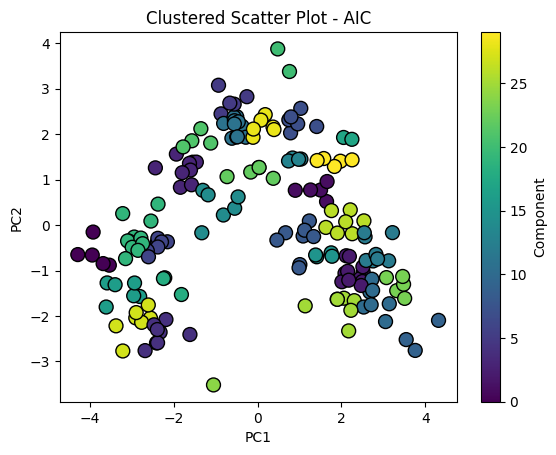

In [197]:
plt.scatter(data[:, 0], data[:, 1], c=labels_aic, cmap='viridis', s=100, edgecolor='k')
plt.title('Clustered Scatter Plot - AIC')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Component')
plt.show()

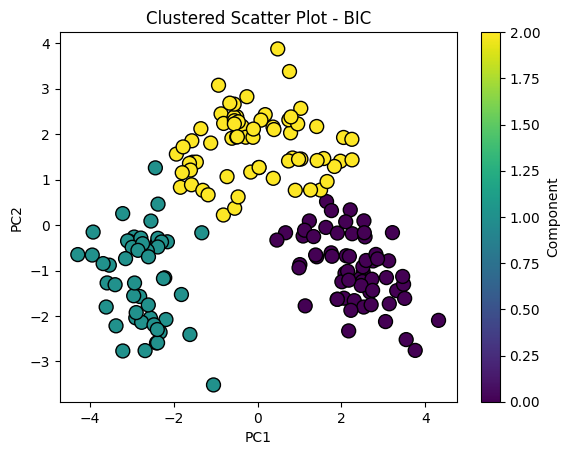

In [198]:
plt.scatter(data[:, 0], data[:, 1], c=labels_bic, cmap='viridis', s=100, edgecolor='k')
plt.title('Clustered Scatter Plot - BIC')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Component')
plt.show()

With a higher silhoutte score and the best plots created, it is obvious that the count for BIC is more exact and accurate for clustering.